# **Data Mining & Foundations of AI (Assessment 2)**
<h3><b>100568617</b></h3>

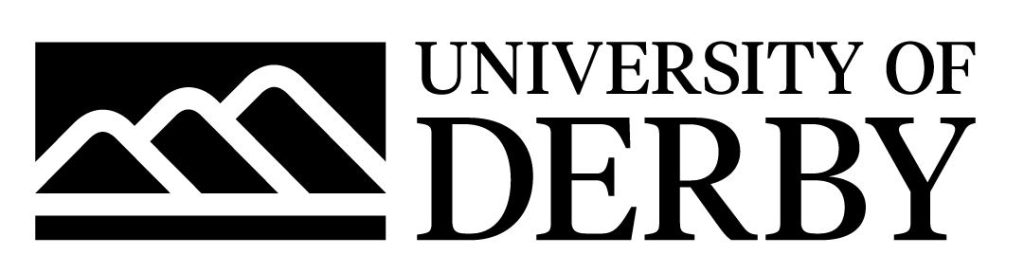

---

# **About Dataset - Chest X-Ray Images (Pneumonia)**

The dataset comes from a study published in Cell, illustrating chest X-ray images in patients with pneumonia. It discusses the distinctions between normal chest X-rays, bacterial pneumonia, and viral pneumonia.

The dataset is structured into three main folders, train, test and val, each containing subfolders for two image categories: Pneumonia and Normal. In total, there are 5,853 JPEG images available for analysis, representing the two categories.

These images, captured in anterior-posterior view, were obtained from paediatric patients ages one to five years old at Guangzhou Women and Children's Medical Center, Guangzhou. The imaging was part of the patient’s routine clinical care.

Measures to ensure quality include the removal of low-quality or unreadable scans. Expert physicians graded the diagnoses for each image before training AI systems. To mitigate grading errors, a third expert reviewed the set.

Original Study: [Cell Study](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

Dataset: [Data Source](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)

Creative Commons License : [CC License](https://creativecommons.org/licenses/by/4.0/)

---

# **About Notebook**

In this notebook a custom model using CNN will be made based from the comparison of different models from 100568617-PREMADEMODELS and will try to improve on the base line architectures taking inspiration from RestNet50, EfficientNetB0 and InceptionV3 to try and make an effective model for classifying images for pneumonia patients.

This process follows principles of [The typical transfer-learning workflow](https://keras.io/guides/transfer_learning/) to try and perform an effective and fair test

***Model Overview***
1. CNN Model based from (ResNet50, EfficientNetB0, InceptionV3)

# **Import Packages & Libraries**

In [541]:
# Importing necessary packages and libraries

# Operating system interface for file and directory management
import os 

# Base python library for randomisation of data
import random

# Numerical and data manipulation libraries
import numpy as np 
import pandas as pd 
import cv2  # OpenCV for image processing

# Visualisation Package for Data insights
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow Keras modules for deep learning model building and preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, EfficientNetB0, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


# Packages for XAI visualising model Evaluations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage.segmentation import mark_boundaries, felzenszwalb
import lime

# **Paths for Training Sets**

In [152]:
train_path = '/kaggle/input/chest_xray/train'
test_path = '/kaggle/input/chest_xray/test'
val_path = '/kaggle/input/chest_xray/val'

# **Loading Datasets**


In [190]:
# Define the data augmentation model
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

# Optimize data loading
def load_data(directory, img_size=(150, 125), batch_size=32, augment=False, colour_samples='grayscale'):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='binary',
        color_mode=colour_samples,
        image_size=img_size,
        batch_size=batch_size,
        crop_to_aspect_ratio=True, 
        seed=42 # Effort to maintain reproducability
    )

    if augment:
        # Augment the train dataset to prevent overfitting
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
    
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [191]:
train_ds = load_data(train_path, augment=True)
val_ds = load_data(val_path)
test_ds = load_data(test_path)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


# **Data Preprocessing & Preprocessing**

## **Visualise Function**

Inspired by [Chest X-Ray | Xception | 94%](https://www.kaggle.com/code/abdmental01/chest-x-ray-xception-94)

In [155]:
def visualise_distribution(dataset, dataset_type):
    """
    Visualizes the distribution of normal and pneumonic cases in the given dataset.

    Args:
    dataset (tf.data.Dataset): The dataset containing image-label pairs.
    dataset_type (str): A string indicating the type of the dataset (e.g., 'train', 'validation', 'test').

    """
    
    # Initialize counters for pneumonia and normal cases
    pneumonia_count = 0
    normal_count = 0

    # Iterate through the dataset to count the number of pneumonia and normal cases
    for x, y in dataset: 
        for value in y: 
            if value == 1: 
                pneumonia_count += 1
            if value == 0: 
                normal_count += 1
    
    # Calculate the total number of cases
    total_count = pneumonia_count + normal_count
    
    # Print a summary of the counts and their percentages
    print(f'Examples in {dataset_type}_ds:\n    Total: {total_count}\n    Pneumonia: {pneumonia_count} ({100 * pneumonia_count / total_count:.2f}% of total)\n    Normal: {normal_count} ({100 * normal_count / total_count:.2f}% of total)')

    # Set up the figure size for the plots
    plt.figure(figsize=(12, 5))

    # Bar Chart to visualize the count of each class
    plt.subplot(1, 2, 1)
    plt.bar(['PNEUMONIA', 'NORMAL'], [pneumonia_count, normal_count], color=['#ff9999', '#66b3ff'])
    plt.title(f'{dataset_type.capitalize()} Set - Bar Chart')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.ylim(0, max(pneumonia_count, normal_count) * 1.1)  # Set the y-limit slightly above the highest count for better visualization

    # Pie Chart to visualize the proportion of each class
    plt.subplot(1, 2, 2)
    plt.pie([pneumonia_count, normal_count], labels=['PNEUMONIA', 'NORMAL'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
    plt.title(f'{dataset_type.capitalize()} Set - Pie Chart')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Display the plots
    plt.show()

## **Train Set Distribution**

Examples in train_ds:
    Total: 5216
    Pneumonia: 3875 (74.29% of total)
    Normal: 1341 (25.71% of total)


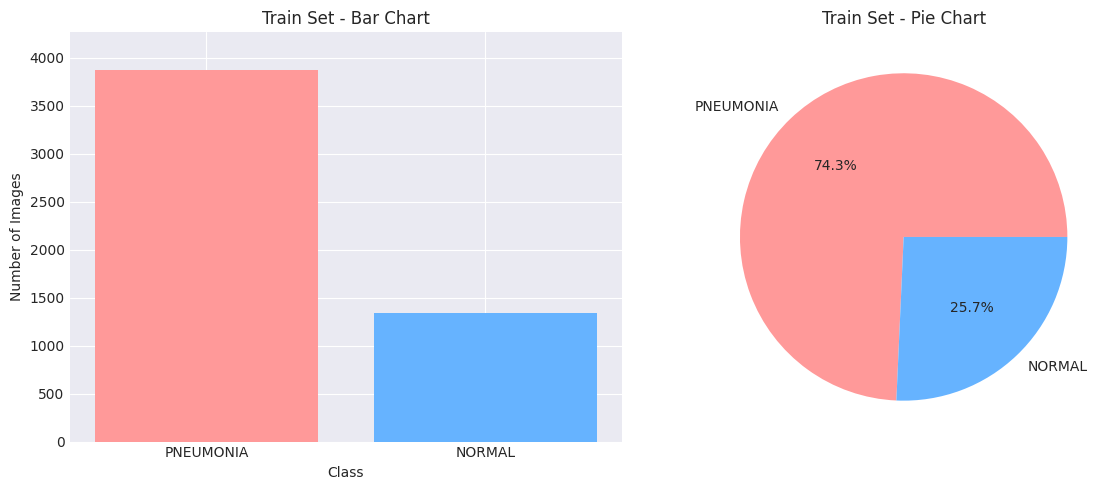

In [156]:
visualise_distribution(train_ds, 'train')

## **Test Set Distribution**

Examples in test_ds:
    Total: 624
    Pneumonia: 390 (62.50% of total)
    Normal: 234 (37.50% of total)


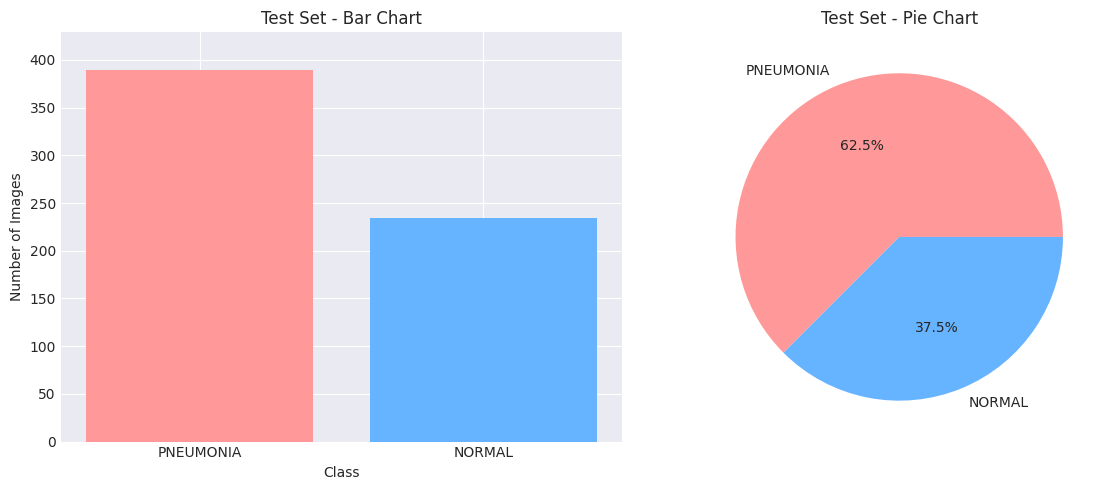

In [157]:
visualise_distribution(test_ds, 'test')

## **Plot X-Ray Images**


Inspired by: [Pneumonia Detection Using CNN in Python](https://www.geeksforgeeks.org/pneumonia-detection-using-cnn-in-python/)

In [158]:
def visualise_images_from_directory(directory, class_name, num_images=5):
    """
    Visualizes a specified number of images from a given class in a directory.

    Args:
    directory (str): The path to the directory containing the image classes.
    class_name (str): The name of the class to visualize images from.
    num_images (int): The number of images to visualize (default is 5).
    """
    
    # Set up the figure size for the plot
    fig = plt.gcf()
    fig.set_size_inches(16, 8)
    
    # Construct the path to the specified class directory
    path = os.path.join(directory, class_name)

    # Get a list of all image files in the class directory
    all_images = os.listdir(path)
    # Select the first 'num_images' from the list of images
    example_images = all_images[:num_images]

    # Loop through the selected example images
    for i, img_name in enumerate(example_images):
        # Construct the full path to each image
        img_path = os.path.join(path, img_name)
        # Read the image using OpenCV
        img = cv2.imread(img_path)
        # Convert the image from BGR (OpenCV format) to RGB (matplotlib format)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Create a subplot for each image
        plt.subplot(1, num_images, i + 1)
        # Display the image
        plt.imshow(img)
        # Set the title of the subplot to the class name
        plt.title(class_name)
        # Turn off the axis for a cleaner look
        plt.axis('off')
    
    # Display the entire plot
    plt.show()

In [159]:
directory = '/kaggle/input/chest_xray/train/'

### **Unprocessed Images for Pneumonic Patients**

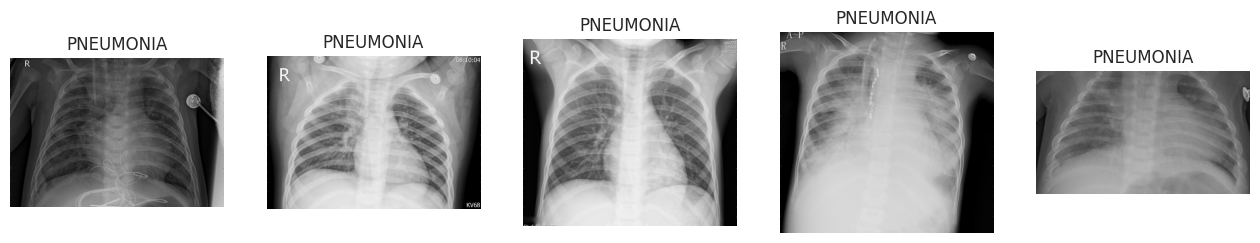

In [160]:
visualise_images_from_directory(directory, 'PNEUMONIA', num_images=5)

### **Unprocessed Images for Normal Patients**

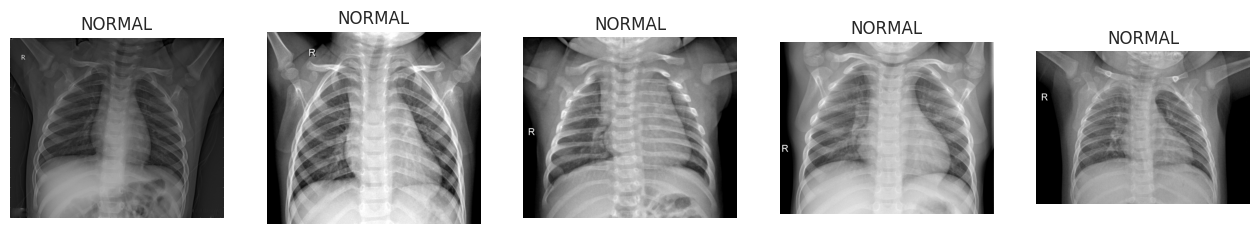

In [161]:
visualise_images_from_directory(directory,'NORMAL', num_images=5)

# **Data Evaulation Functions**

In [162]:
def generate_confusion_matrix(model, test_generator): 
    """
    generates a confusion matrix and displays the matrix plot
    Args: 
        model: the model that is being tested
        test_generator: the test dataset
        
    """
    
    # Generate predictions
    true_labels  = np.concatenate([y for x, y in test_generator], axis=0)
    predicted_labels  = np.concatenate([model.predict(x) for x, y in test_generator], axis=0)
    predicted_labels  = np.round(predicted_labels).astype(int)

    # Compute confusion matrix
    confusion_mtx  = confusion_matrix(true_labels, predicted_labels)
    display  = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=['Normal', 'Pneumonia'])

    # Display confusion matrix
    display.plot(cmap='Blues')
    plt.show()

# **Custom CNN Model**

The initial Conv2D layer with 32 filters, BatchNormalization, and MaxPooling2D extracts low-level features like edges and textures. Batch normalization stabilizes training, while max pooling reduces spatial dimensions, cutting computational costs and avoiding overfitting.

The Residual Block, inspired by ResNet50, includes two Conv2D layers with 64 filters, BatchNormalization, and a residual connection. This setup prevents the vanishing gradient problem, allowing deeper networks and ensuring effective gradient flow during backpropagation, which improves training stability and convergence.

The Inception Block, derived from InceptionV3, consists of parallel Conv2D layers with different filter sizes (1x1, 3x3, 5x5) and MaxPooling2D, followed by Concatenate. This module captures multi-scale features, enhancing the network's ability to detect complex patterns and structures in images.

The Efficient Scaling Block, inspired by EfficientNetB0, features two Conv2D layers with 128 filters, BatchNormalization, a residual connection, and GlobalAveragePooling2D. It balances network depth, width, and resolution, with residual connections ensuring stability and global average pooling reducing parameters to prevent overfitting and capture global context.

The model ends with a Dense layer with 1 unit and sigmoid activation for binary classification, producing a probability score suitable for tasks like detecting pneumonia.

Combining these components, the custom CNN model leverages the strengths of each architecture, aiming for a high-performing and robust image classification model capable of capturing a wide range of features and patterns.

Similar techniques used for the PREMADE models trying to use best practice based on [The typical transfer-learning workflow](https://keras.io/guides/transfer_learning/)

In [163]:
# Early stopping callback to stop training when the monitored metric has stopped improving
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Reduce learning rate when 'val_loss' stops improving
# Reduce the learning rate by a factor of 0.2 after 3 epochs of no improvement
# Set a minimum learning rate of 0.001
reduced_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001) 

callbacks = [early_stopping, reduced_plateau]

## **Training Top layers**

In [164]:
def train_top_layers(model, train_generator, val_generator, callbacks=callbacks):
    """
    Train the top layers of a model using the typical transfer learning workflow in Keras.

    Args:
        model (tf.keras.Model): The model to train.
        train_generator (tf.data.Dataset): The training dataset.
        val_generator (tf.data.Dataset): The validation dataset to compare against the training set.
        callbacks (array): The array of callbacks for enhanced tuning
        
    Returns:
        tf.keras.callbacks.History: The history object containing training details for model evaluation.
    """
    # Compile the model with an Adam optimizer, binary cross-entropy loss, and binary accuracy metric
    model.compile(
        optimizer=keras.optimizers.Adam(),  # Use the Adam optimizer
        loss=keras.losses.BinaryCrossentropy(from_logits=True),  # Loss function for binary classification
        metrics=[keras.metrics.BinaryAccuracy()]  # Evaluation metric to track binary accuracy
    )
    
    # Train the model using the training and validation datasets
    history = model.fit(
        train_generator,  # Training dataset
        epochs=2,  # Number of epochs to train the model
        validation_data=val_generator,  # Validation dataset for evaluation
        callbacks=callbacks  # List of callback functions to apply during training
    )
    
    return history  # Return the history object containing training details

## **Fine Tune Model Performance Based on Keras Transfer Learning**

In [165]:
def fine_tune(model, train_generator, val_generator, callbacks=callbacks):
    """
    Fine-tune a previously trained model to improve its performance.

    Args:
        model (tf.keras.Model): The pre-trained model to be fine-tuned.
        train_generator (tf.data.Dataset): The training dataset.
        val_generator (tf.data.Dataset): The validation dataset to compare against the training set.
        callbacks (array): The array of callbacks for fine tuning

    Returns:
        tf.keras.callbacks.History: The history object containing training details for model evaluation.
    """
    # Make the entire model trainable
    model.trainable = True

    # Compile the model with a low learning rate, appropriate loss function, and evaluation metrics
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate for fine-tuning
        loss=keras.losses.BinaryCrossentropy(from_logits=True),  # Loss function for binary classification
        metrics=[keras.metrics.BinaryAccuracy()],  # Evaluation metric to track binary accuracy
    )

    # Train the model using the training and validation datasets
    history = model.fit(
        train_generator,  # Training dataset
        epochs=12,  # Number of epochs for fine-tuning
        validation_data=val_generator,  # Validation dataset for evaluation
        callbacks=callbacks  # List of callback functions to apply during training
    )

    return history  # Return the history object containing training details


## **Construct Custom Model**
Model construction code Inspired by : [Pneumonia Detection using CNN(92.6% Accuracy)](https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy/notebook)

Adapted based on the architechture of ResNet50, EfficientNetB0, InceptionV3

In [166]:
def custom_base_model(input_shape=(150, 125, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # First Conv Layer
    # Initial Conv2D layer with 32 filters, BatchNormalization, and MaxPooling2D
    # This extracts low-level features such as edges and textures, 
    # with BatchNormalization stabilizing the training process 
    # and MaxPooling2D reducing spatial dimensions to cut computational costs and mitigate overfitting
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Residual Block 1
    # Two Conv2D layers with 64 filters and BatchNormalization
    # Adding a residual connection to prevent the vanishing gradient problem,
    # inspired by ResNet50, allowing deeper networks and ensuring effective gradient flow during backpropagation.
    res1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    res1 = layers.BatchNormalization()(res1)
    res1 = layers.Conv2D(64, (3, 3), padding='same')(res1)
    res1 = layers.BatchNormalization()(res1)
    
    # Residual Block 1
    # Two Conv2D layers with 64 filters and BatchNormalization
    # Adding a residual connection to prevent the vanishing gradient problem,
    # inspired by ResNet50, allowing deeper networks and ensuring effective gradient flow during backpropagation.
    shortcut = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    res1 = layers.Add()([shortcut, res1])
    res1 = layers.Activation('relu')(res1)
    res1 = layers.MaxPooling2D(pool_size=(2, 2))(res1)

    # Inception Block
    # Multiple parallel Conv2D layers with different filter sizes (1x1, 3x3, 5x5) and MaxPooling2D, followed by Concatenate
    # Inspired by InceptionV3, this captures multi-scale features, enhancing the network's ability 
    # to detect complex patterns and structures in the images.
    incep1 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(res1)
    incep1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(incep1)
    
    incep2 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(res1)
    incep2 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(incep2)
    
    incep3 = layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(res1)
    incep3 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(incep3)
    
    incep4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(res1)
    
    incep_concat = layers.Concatenate()([incep1, incep2, incep3, incep4])
    incep_concat = layers.MaxPooling2D(pool_size=(2, 2))(incep_concat)

    # Efficient Scaling Block
    # Two Conv2D layers with 128 filters and BatchNormalization
    # Adding a residual connection and GlobalAveragePooling2D
    # Inspired by EfficientNetB0, this balances network depth, width, and resolution,
    # with residual connections ensuring stability and global average pooling reducing parameters
    # to prevent overfitting and capture global context.
    eff1 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(incep_concat)
    eff1 = layers.BatchNormalization()(eff1)
    eff1 = layers.Conv2D(128, (3, 3), padding='same')(eff1)
    eff1 = layers.BatchNormalization()(eff1)
    
    # Adjust input dimensions to match residual output
    shortcut = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(incep_concat)
    eff1 = layers.Add()([shortcut, eff1])
    eff1 = layers.Activation('relu')(eff1)
    eff1 = layers.GlobalAveragePooling2D()(eff1)

    base_model = Model(inputs, eff1)
    return base_model

## **Build the Cstom Model**

In [167]:
def build_custom_model(img_size=(150, 125, 1), num_classes=1):
    base_model = custom_base_model(input_shape=img_size)
    inputs = tf.keras.Input(shape=img_size)
    scale_layer = layers.Rescaling(scale=1/127.5, offset=-1)(inputs)  # Normalize input
    x = base_model(scale_layer, training=False)  # Ensure base model runs in inference mode
    x = layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(x)  # Adjust for binary or multi-class classification
    model = Model(inputs, outputs)
    return model

## **Tranining The Model**

In [168]:
cnn_model = build_custom_model()

In [169]:
cnn_model_history = train_top_layers(cnn_model, train_ds, val_ds)

Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - binary_accuracy: 0.8834 - loss: 0.2778 - val_binary_accuracy: 0.5000 - val_loss: 6.5438 - learning_rate: 0.0010
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - binary_accuracy: 0.9253 - loss: 0.1917 - val_binary_accuracy: 0.5000 - val_loss: 7.5119 - learning_rate: 0.0010


In [170]:
cnn_model_history = fine_tune(cnn_model, train_ds, val_ds)

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - binary_accuracy: 0.9264 - loss: 0.1838 - val_binary_accuracy: 0.5000 - val_loss: 5.6831 - learning_rate: 1.0000e-05
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - binary_accuracy: 0.9260 - loss: 0.1852 - val_binary_accuracy: 0.5000 - val_loss: 4.1247 - learning_rate: 1.0000e-05
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - binary_accuracy: 0.9376 - loss: 0.1651 - val_binary_accuracy: 0.5000 - val_loss: 2.0253 - learning_rate: 1.0000e-05
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - binary_accuracy: 0.9327 - loss: 0.1676 - val_binary_accuracy: 0.6250 - val_loss: 0.8013 - learning_rate: 1.0000e-05
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - binary_accuracy: 0.9315 - loss: 0.1719 - val_binary_accuracy: 0.6875 - val_loss: 0.6096 - learning_rate: 1.0000e-05
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - binary_accuracy: 0.9376 - loss: 0.1658 - val_binary_accuracy: 0.6875 - val_loss: 0.5

## **Evaluating CNN Model**

The custom CNN model for pneumonia detection demonstrated notable performance metrics and patterns. The model maintained a high training accuracy near 0.95, indicating effective learning from the training data. However, validation accuracy fluctuated, starting around 0.5 and peaking at epoch 11, suggesting variability in performance on unseen data. The training loss remained consistently low, while the validation loss, initially high, decreased significantly by epoch 4 and stabilized, reflecting some instability but overall improvement.

The confusion matrix revealed that the model correctly identified 267 pneumonia cases and 84 normal cases but mislabeled 123 normal cases as pneumonia and 150 pneumonia cases as normal, resulting in an overall accuracy of 66.67%. The sample predictions included true positives (correctly identifying pneumonia), false positives (normal cases predicted as pneumonia), true negatives (correctly identifying normal cases), and false negatives (pneumonia cases predicted as normal).

During initial training, the model achieved binary accuracies of 0.8834 and 0.9253, but the validation accuracy was 0.5000 with high validation loss, indicating potential overfitting. Fine-tuning over 12 epochs gradually improved validation performance, with accuracy increasing to 0.6875 and validation loss decreasing significantly.

The model architecture consisted of an input layer for image processing, a rescaling layer for pixel normalization, custom CNN layers for feature extraction, a dropout layer to prevent overfitting, and a dense layer for classification. With over 2 million parameters, around 690,000 of which were trainable, the model effectively distinguished between normal and pneumonia cases.

Compared to pretrained models like ResNet50 and EfficientNetB0, which typically achieve around 92.6% accuracy, the custom CNN model's validation accuracy was lower at 66.67%. However, it showed better balance in recall and precision, crucial for medical diagnostics. The model incorporated advanced techniques such as residual connections, inception blocks, and potentially LSTM layers for understanding spatial and sequential patterns. Optimizations, including data augmentation and converting grayscale images to RGB, along with fine-tuning and learning rate adjustments, contributed to its performance.

### **Summary, Accuracy, Confusion Matrix**

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 125, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 125, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_8 (Functional)       │ (None, 128)            │       691,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,071,941 (7.90 MB)

 Trainable params: 690,369 (2.63 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 1,380,740 (5.27 MB)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - binary_accuracy: 0.8617 - loss: 0.3717

 Validation Loss: 0.3765891492366791  Validation Accuracy: 86.06 %


Here is a confusion matrix for Custom CNN Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


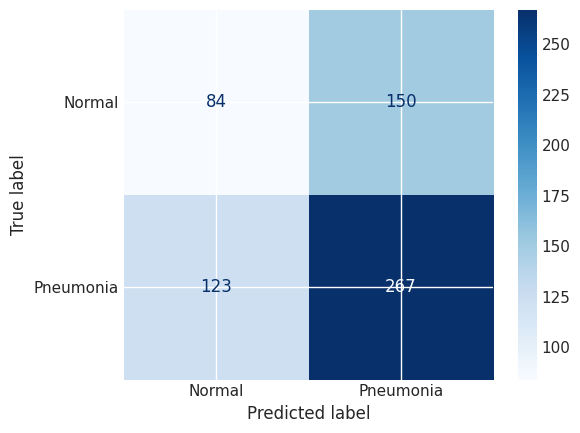


Here is the prediction for the model

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

--------------------------------------------------------



In [156]:
def summerise_model(model, train_ds, test_ds):
    """
    Summarizes the given model by printing its architecture, evaluating it on the test dataset,
    generating a confusion matrix, and displaying predictions.

    Args:
        model (tf.keras.Model): The trained model to be summarized.
        train_ds (tf.data.Dataset): The training dataset.
        test_ds (tf.data.Dataset): The testing dataset.
    """

    # Print the summary of the current model
    model.summary()

    # Evaluate the model on the test dataset and print the validation loss and accuracy
    validation_loss, validation_accuracy = model.evaluate(test_ds)
    print(f'\n Validation Loss: {validation_loss}  Validation Accuracy: {validation_accuracy*100:.2f} %\n')

    # Generate and print the confusion matrix for the current model
    print('\nHere is a confusion matrix for Custom CNN Model\n')
    generate_confusion_matrix(model, test_ds)
    
    # Print a message indicating that predictions will be displayed
    print(f'\nHere is the prediction for the model\n')
    predictions = model.predict(test_ds)

    # Print a separator for better readability
    print('\n--------------------------------------------------------\n')
    
    return predictions

# Call the function to summarize the model
predictions = summerise_model(cnn_model, train_ds, test_ds)

### **Visualising the Predictions**

Inspired by : [Pneumonia Detection using CNN(92.6% Accuracy)](https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy/notebook)

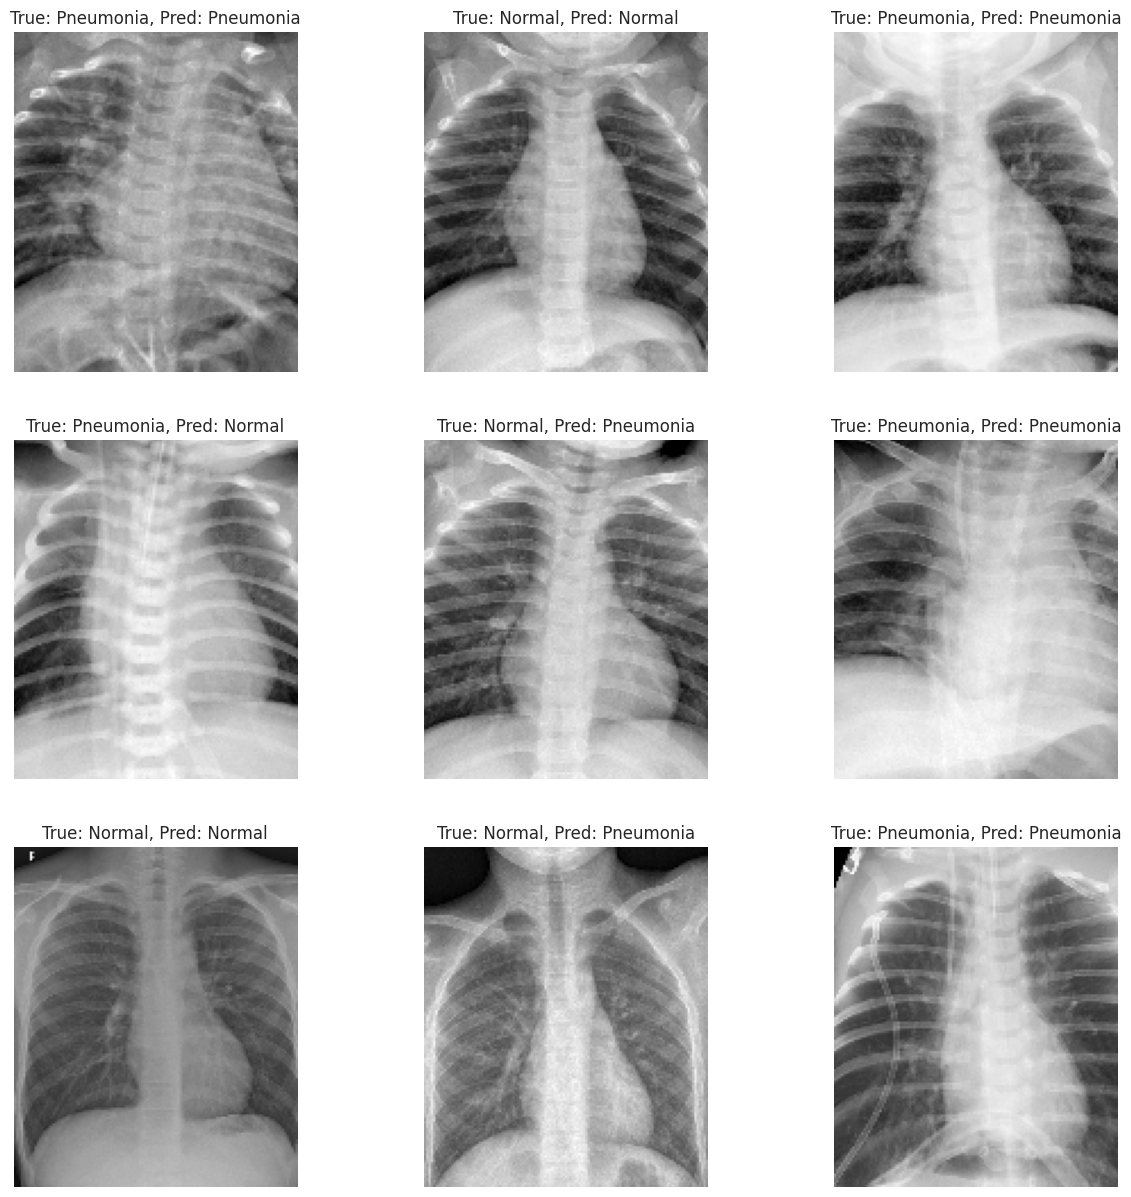

Percentage of correct predictions: 66.67%


In [144]:
def visualise_predictions(dataset, predictions, num_images=9):
    """
    Visualize the predictions of the model on a subset of the dataset.

    Args:
        dataset (tf.data.Dataset): Dataset containing images and labels.
        predictions (numpy.ndarray): Array of predictions from the model.
        num_images (int): Number of images to visualize. Default is 9.

    Displays:
        Matplotlib grid with the true and predicted labels for the specified number of images.
        Prints the percentage of correct predictions.
    """
    class_names = ['Normal', 'Pneumonia']
    plt.figure(figsize=(15, 15))  # Set the figure size for the plot
    correct_predictions = 0  # Initialize counter for correct predictions
    total_predictions = num_images  # Total number of predictions to display

    # Iterate through the dataset to take one batch
    for iteration, (images, labels) in enumerate(dataset.take(1)):
        for x in range(num_images):
            ax = plt.subplot(3, 3, x + 1)  # Axes
            plt.imshow(images[x].numpy().astype("uint8"), cmap='gray')
            true_label = class_names[int(labels[x])]  # Get the true label
            predicted_label = class_names[int(np.round(predictions[x].item()))]  # Get the predicted label
            if true_label == predicted_label:
                correct_predictions += 1
            plt.title(f'True: {true_label}, Pred: {predicted_label}')
            plt.axis("off")
        plt.show()

    # Calculate and print percentage of correct predictions
    accuracy = (correct_predictions / total_predictions) * 100
    print(f'Percentage of correct predictions: {accuracy:.2f}%')
visualise_predictions(test_ds, predictions)

### **Model History**

Snippet: [Chest X-Ray | Xception | 94%](https://www.kaggle.com/code/abdmental01/chest-x-ray-xception-94)

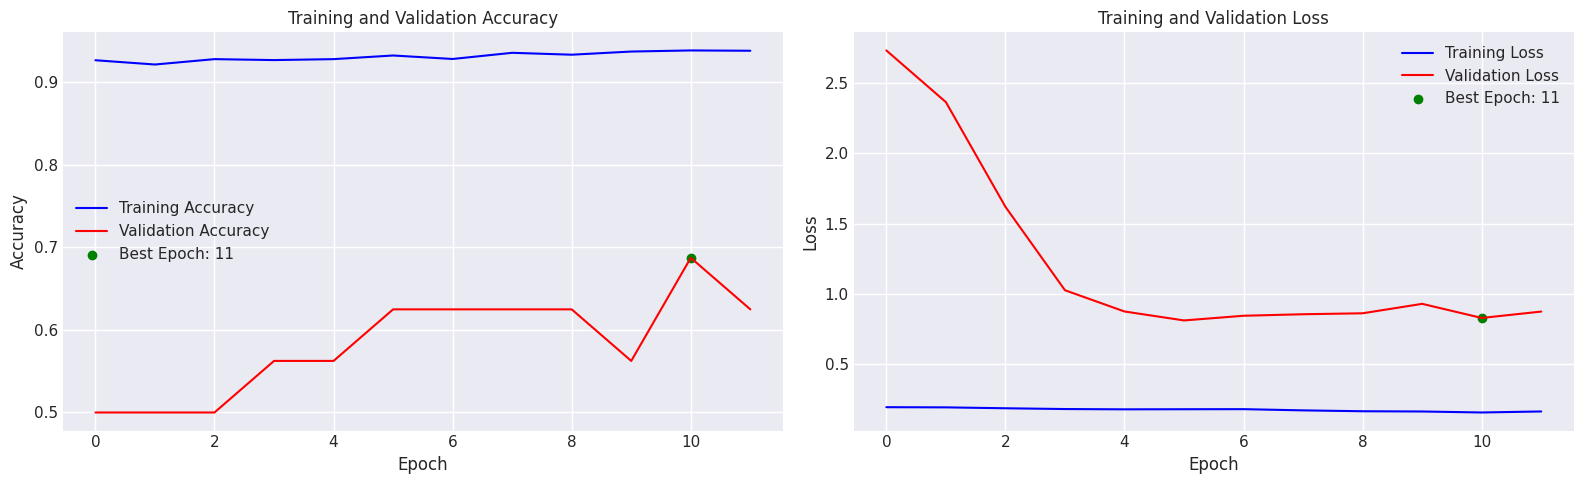

In [155]:
# Get the epoch with the highest validation accuracy
best_epoch = cnn_model_history.history['val_binary_accuracy'].index(max(cnn_model_history.history['val_binary_accuracy'])) + 1

# Set the background style using seaborn
sns.set_style('darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(cnn_model_history.history['binary_accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(cnn_model_history.history['val_binary_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, cnn_model_history.history['val_binary_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(cnn_model_history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(cnn_model_history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, cnn_model_history.history['val_loss'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

## **LIME Representation**

This section visualises the predicton using masking with the lime XAI visualiser. Two masks have been implemented to identify negative and positve decision making of the model. 

Inspiration from: [Deep Learning and Explainable AI using LIME](https://www.kaggle.com/code/deekshith39/deep-learning-and-explainable-ai-using-lime) 

In [633]:
def preprocess_image(image):
    """
    Preprocess the input image for LIME.

    Args:
        image (numpy.ndarray): Input image in grayscale.

    Returns:
        numpy.ndarray: Preprocessed image ready for LIME with shape (1, 150, 125, 3).
    """
    # Cast the image to float32
    image = tf.cast(image, tf.float32)
    
    # Normalize the image
    image = image / 255.0
    
    # Add the channel dimension for grayscale (1 channel)
    image = tf.reshape(image, (150, 125, 1))
    
    # Convert the grayscale image to RGB by stacking the grayscale image along the third axis for LIME
    image_rgb_for_lime = tf.stack([image, image, image], axis=-1)
    
    # Add the batch dimension to the image
    image_rgb_for_lime = tf.reshape(image_rgb_for_lime, (1, 150, 125, 3))
    
    return image_rgb_for_lime

### **Visualise the Data**

In [673]:
def visualise_explanation(image, explanation, index, y_pred, y_test):
    """
    Visualize the LIME explanation.

    Args:
        image (tensorflow.Tensor): Original input image in grayscale.
        explanation (lime_image.ImageExplanation): LIME explanation object.
        index (int): Index of the image in the dataset.
        y_pred (list): List of predicted labels.
        y_test (list): List of ground truth labels.

    Displays:
        Matplotlib plot with the LIME explanation overlay on the original image.
    """
    # Convert the TensorFlow tensor to a NumPy array
    image_np = image.numpy()

    # Get image and mask from LIME explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    # Display the result
    fig, ax = plt.subplots()

    # Display the original grayscale image
    ax.imshow(np.squeeze(image_np), cmap='gray', interpolation='none')

    # Overlay the mask
    ax.imshow(mark_boundaries(temp / 2 + 0.5, mask))

    # Add titles and descriptions
    prediction_label = 'Pneumonia' if y_pred[index] == 0 else 'Normal'
    ground_truth_label = 'Pneumonia' if y_test[index] == 0 else 'Normal'
    ax.set_title(f'Predicted - {prediction_label}\nGround Truth - {ground_truth_label}\nGreen Regions -> Supporting the predicted label\nRed Regions -> Against the predicted label')

    # Hide the axes for better visualization
    ax.axis('off')

    plt.show()


### **Prediction Function to Format back into Grayscale**

In [615]:
def predict_fn(images, model):
    """
    Predict function compatible with LIME.

    Args:
        images (numpy.ndarray): Batch of images in RGB format.
        model (tf.keras.Model): Trained model for prediction.

    Returns:
        numpy.ndarray: Model predictions.
    """
    images = np.array(images)
    # Convert RGB images back to grayscale before making a prediction
    images_grayscale = np.mean(images, axis=-1, keepdims=True)
    return model.predict(images_grayscale)

### **Creating the Label sets for Indexing**

In [638]:
y_pred = []
y_test = []
        
for x in preds: 
    if x == 1: 
        y_pred.append(0)
    else: 
        y_pred.append(1)
        
for iteration, (images, labels) in enumerate(test_ds):
    for x in labels:
        x = x.numpy()
        y_test.append(int(x[0]))
        
np.array(y_pred)
np.array(y_test)

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,

### **Explain the Test Data**

In [671]:
def explain(dataset, num_images, model, y_pred, y_test):
    """
    Explain model predictions using LIME and visualize the explanations.

    Args:
        dataset (tf.data.Dataset): The dataset containing images and labels.
        num_images (int): The number of images to explain and visualize.
        model (tf.keras.Model): The trained model to be explained.
        y_pred (list): List of predicted labels.
        y_test (list): List of ground truth labels.

    Returns:
        None
    """
    # Create a LIME image explainer object
    explainer = lime_image.LimeImageExplainer()
    
    # Initialize a counter to keep track of the number of images processed
    count = 0
    
    # Iterate over the batches in the dataset
    for batch_index, (images, labels) in enumerate(dataset):
        # Iterate over each image in the batch
        for image_index, image in enumerate(images):
            # Preprocess the image for LIME
            image_rgb_for_lime = preprocess_image(image).numpy()
            
            # Generate an explanation for the preprocessed image
            explanation = explainer.explain_instance(
                image_rgb_for_lime[0],  # The image to explain
                lambda x: predict_fn(x, model),  # Prediction function
                top_labels=5,  # Number of top labels to explain
                hide_color=0,  # Color to hide the superpixels
                num_samples=64,  # Number of samples to generate
            )
  
            # Visualize the explanation
            visualize_explanation(image, explanation, count, y_pred, y_test)
            
            # Increment the count after processing an image
            count += 1
            # If the count reaches the specified number of images, stop processing
            if count >= num_images:
                return


  0%|          | 0/64 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


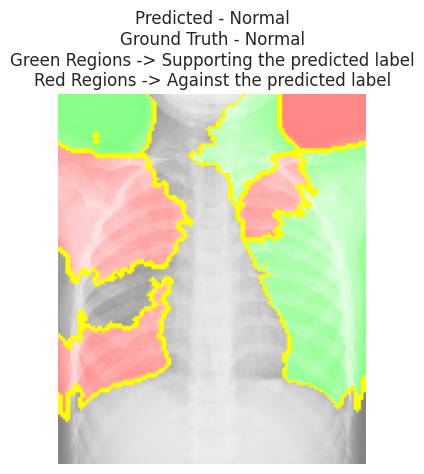

  0%|          | 0/64 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


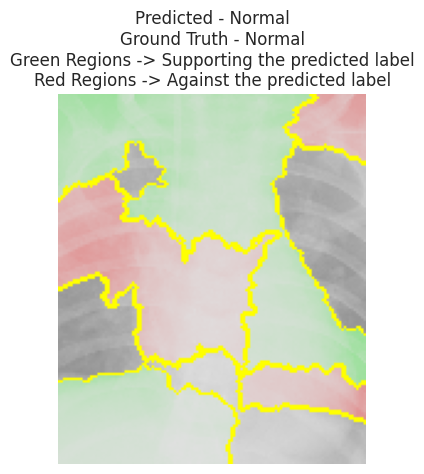

  0%|          | 0/64 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


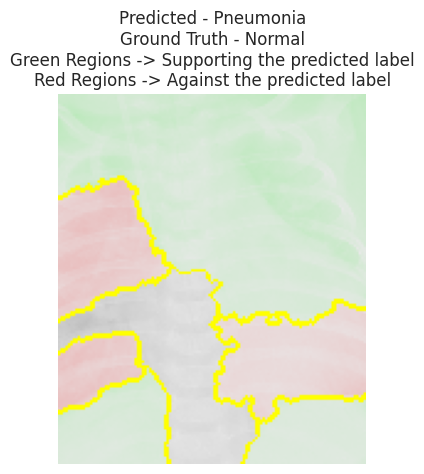

  0%|          | 0/64 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


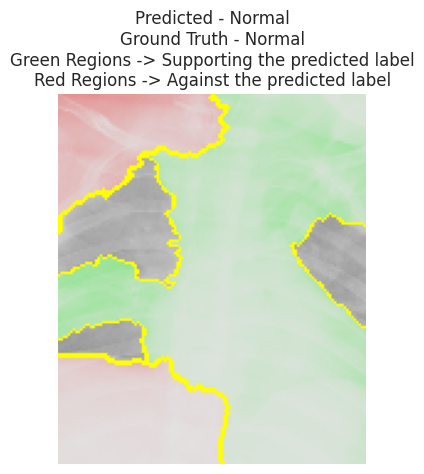

In [670]:
explain(test_ds, 4, model=cnn_model, y_test=y_pred, y_pred=y_test)